# 4x1 Beam with Rolling Load

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json
from scipy import signal

from diffmpm.constraint import Constraint
from diffmpm.element import Quadrilateral4Node
from diffmpm.material import LinearElastic
from diffmpm.mesh import Mesh2D
from diffmpm.particle import Particles
from diffmpm.solver import MPMExplicit
from diffmpm.functions import Linear, Unit
from diffmpm.forces import NodalForce, ParticleTraction
import diffmpm.writers as writers

def rolling_gaussian_generator(velocity, frequency, node_x_locs, N=5):
    time_to_center = node_x_locs / velocity

    fc = frequency
    N = N  # number of cycles to capture on either side of peak
    t_width = N / fc  # half-width of time range

    t = jnp.linspace(-t_width, t_width, 2 * 100, endpoint=False)
    i, q, e = signal.gausspulse(t, fc=fc, retquad=True, retenv=True)

    t = jnp.insert(t, 0, -t_width - 1e-16)
    t = jnp.append(t, t_width + 1e-16)
    e = jnp.insert(e, 0, 0)
    e = jnp.append(e, 0)

    xvalues = t + time_to_center[:, jnp.newaxis]
    fxvalues = e
    return xvalues, fxvalues


# material
E_true = 1000
material = LinearElastic({"youngs_modulus": E_true, "poisson_ratio" : 0, "density": 1, "id" : 0})

# particles
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))
particles = Particles(ploc, material, jnp.array([0]))

# external forces
velocity = 50
frequency = 5
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
true_f = -10
for i in range(5):
    fn = Linear(i, xvalues[i, :], fxvalues)
    cnfs.append(NodalForce(node_ids=[5 + i], function=fn, dir=1, force=true_f))
pst = []

# element
constraints = [(jnp.array([0]), Constraint(0, 0.0)), (jnp.array([0,4]), Constraint(1, 0.0))]
elements = Quadrilateral4Node(
    [4,1], 4, [1, 1], constraints, concentrated_nodal_forces=cnfs
    )

# mesh
mesh = Mesh2D({
    "particles": [particles], 
    "elements": elements, 
    "particle_surface_traction" : []
    })

# scheme
dt = 0.01
nsteps = 10
mpm = MPMExplicit(
    mesh, 
    dt, 
    scheme="usl", 
    sim_steps=nsteps, 
    out_dir="results_rolling/",
    writer_func=writers.NPZWriter().write
    )
true_result = mpm.solve_jit_history(0)

true_result["strain"]


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([[[ 0.00000000e+00, -3.74777778e-03,  0.00000000e+00,
          2.52222555e-04,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.74777778e-03,  0.00000000e+00,
          7.56667636e-04,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.74777778e-03,  0.00000000e+00,
          1.26111263e-03,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00, -3.26470635e-03,  0.00000000e+00,
         -6.08208706e-04,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.26470635e-03,  0.00000000e+00,
         -1.01368118e-03,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.26470635e-03,  0.00000000e+00,
         -1.41915365e-03,  0.00000000e+00,  0.00000000e+00]],

       [[ 5.12164152e-05, -8.67306907e-03,  0.00000000e+00,
         -7.02475663e-04,  0.00000000e+00,  0.00000000e+00],
        [ 5.06354991e-05, -8.67306907e-03,  0.00000000e+00,
          6.84998406e-04,  0.00000000e+00,  0.00000000e+00],
        [ 5.00545

E: 1001.011962890625, f2: -9.987445831298828, v: 49.878631591796875 fz: 4.999896049499512: 100%|██████████| 10000/10000 [05:50<00:00, 28.54it/s] 


Text(0.5, 1.0, 'fz')

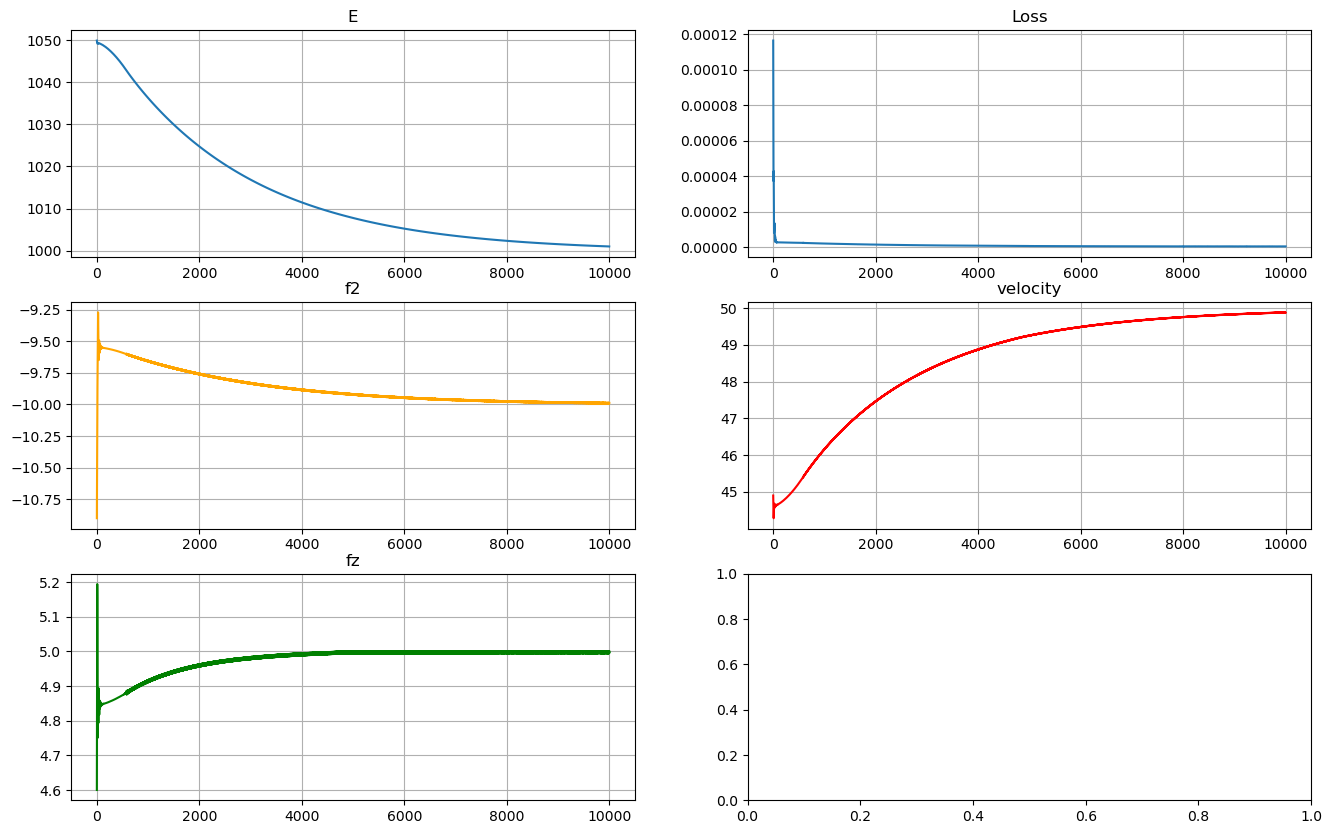

In [7]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json
from scipy import signal

from diffmpm.constraint import Constraint
from diffmpm.element import Quadrilateral4Node
from diffmpm.material import LinearElastic
from diffmpm.mesh import Mesh2D
from diffmpm.particle import Particles
from diffmpm.solver import MPMExplicit
from diffmpm.functions import Linear, Unit
from diffmpm.forces import NodalForce, ParticleTraction
import diffmpm.writers as writers
@jit
def rolling_gaussian_generator(velocity, frequency, node_x_locs, N=5):
    time_to_center = node_x_locs / velocity

    fc = frequency
    t_width = N / fc  # half-width of time range

    t = jnp.linspace(-t_width, t_width, 2 * 100, endpoint=False)
    i, q, e = gausspulse(t, fc=fc)

    t_pad = jnp.array([-t_width - 1e-16, t_width + 1e-16])
    e_pad = jnp.array([0, 0])

    t = jnp.concatenate([t_pad[:1], t, t_pad[1:]])
    e = jnp.concatenate([e_pad[:1], e, e_pad[1:]])

    xvalues = t + time_to_center[:, jnp.newaxis]
    fxvalues = e
    return xvalues, fxvalues

@jit
def gausspulse(t, fc=1000, bw=0.5, bwr=-6):
    """
    Return a Gaussian modulated sinusoid:

        ``exp(-a t^2) exp(1j*2*pi*fc*t).``

    Parameters
    ----------
    t : ndarray
        Input array.
    fc : float, optional
        Center frequency (e.g. Hz).  Default is 1000.
    bw : float, optional
        Fractional bandwidth in frequency domain of pulse (e.g. Hz).
        Default is 0.5.
    bwr : float, optional
        Reference level at which fractional bandwidth is calculated (dB).
        Default is -6.

    Returns
    -------
    yI : ndarray
        Real part of signal.
    yQ : ndarray
        Imaginary part of signal.
    yenv : ndarray
        Envelope of signal.
    """

    # Convert t to a jnp array if it's not already
    t = jnp.asarray(t)

    # exp(-a t^2) <->  sqrt(pi/a) exp(-pi^2/a * f^2)  = g(f)
    ref = jnp.power(10.0, bwr / 20.0)
    
    # pi^2/a * fc^2 * bw^2 /4=-log(ref)
    a = -(jnp.pi * fc * bw) ** 2 / (4.0 * jnp.log(ref))

    yenv = jnp.exp(-a * t * t)
    yI = yenv * jnp.cos(2 * jnp.pi * fc * t)
    yQ = yenv * jnp.sin(2 * jnp.pi * fc * t)

    return yI, yQ, yenv

# material
E_true = 1000
material = LinearElastic({"youngs_modulus": E_true, "poisson_ratio" : 0, "density": 1, "id" : 0})

# particles
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))
particles = Particles(ploc, material, jnp.array([0]))

# external forces
velocity = 50
frequency = 5
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
true_f = -10
for i in range(5):
    fn = Linear(i, xvalues[i, :], fxvalues)
    cnfs.append(NodalForce(node_ids=[5 + i], function=fn, dir=1, force=true_f))
pst = []

# element
constraints = [(jnp.array([0]), Constraint(0, 0.0)), (jnp.array([0,4]), Constraint(1, 0.0))]
elements = Quadrilateral4Node(
    [4,1], 4, [1, 1], constraints, concentrated_nodal_forces=cnfs
    )

# mesh
mesh = Mesh2D({
    "particles": [particles], 
    "elements": elements, 
    "particle_surface_traction" : []
    })

# scheme
dt = 0.01
nsteps = 10
mpm = MPMExplicit(
    mesh, 
    dt, 
    scheme="usl", 
    sim_steps=nsteps, 
    out_dir="results_rolling/",
    writer_func=writers.NPZWriter().write
    )
true_result = mpm.solve_jit_history(0)
target_strain = true_result["strain"]
target_rel_strain = jnp.diff(true_result['strain'][:, ::4, 0][:,4:-4], axis=1)

@jit 
def compute_loss(params, ploc, target_rel_strain):
    material = LinearElastic({"youngs_modulus": params[0], "poisson_ratio" : 0, "density": 1, "id" : 0})

    # particles
    particles = Particles(ploc, material, jnp.array([0]))

    # external forces
    xvalues, fxvalues = rolling_gaussian_generator(params[2], params[3], node_x_locs)
    cnfs = []
    for i in range(5):
        fn = Linear(i, xvalues[i, :], fxvalues)
        cnfs.append(NodalForce(node_ids=[5 + i], function=fn, dir=1, force=params[1]))

    # element
    elements.concentrated_nodal_forces = cnfs

    # mesh
    mesh = Mesh2D({
        "particles": [particles], 
        "elements": elements, 
        "particle_surface_traction" : []
        })

    # scheme
    mpm = MPMExplicit(
        mesh, 
        0.01, 
        scheme="usl", 
        sim_steps=nsteps, 
        out_dir="results_temp/",
        writer_func=writers.NPZWriter().write
        )
    result = mpm.solve_jit_history(0)
    rel_strain = jnp.diff(result['strain'][:, ::4, 0][:,4:-4], axis=1)
    loss = jnp.linalg.norm(rel_strain - target_rel_strain)
    return loss

def optax_adam(params, niter, ploc, target_vel):
    # Initialize parameters of the model + optimizer.
    start_learning_rate = 1e-1
    optimizer = optax.adam(start_learning_rate)
    opt_state = optimizer.init(params)

    param_list = []
    loss_list = []
    # A simple update loop.
    t = tqdm(range(niter), desc=f"E: {params[0]} f2: {params[1]} v: {params[2]} fz: {params[3]}")
    for _ in t:
        lo, grads = value_and_grad(compute_loss)(params, ploc, target_vel)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        t.set_description(f"E: {params[0]}, f2: {params[1]}, v: {params[2]} fz: {params[3]}")
        param_list.append(params)
        loss_list.append(lo)
    return param_list, loss_list


params = jnp.array([1050.0, -11.0, 45, 4.5])
param_list, loss_list = optax_adam(params, 10000, ploc, target_rel_strain)  # ADAM optimizer

results = jnp.array(param_list)
fig, ax = plt.subplots(3, 2, figsize=(16, 10))
ax = ax.flat
ax[0].plot(results[:,0], markersize=2)
ax[0].grid()
ax[0].set_title('E')
ax[1].plot(loss_list)
ax[1].grid()
ax[1].set_title('Loss')
ax[2].plot(results[:,1], markersize=2, color='orange')
ax[2].grid()
ax[2].set_title('f2')
ax[3].plot(results[:,2], markersize=2, color='r')
ax[3].grid()
ax[3].set_title('velocity')
ax[4].plot(results[:,3], markersize=2, color='green')
ax[4].grid()
ax[4].set_title('fz')
plt.show()
# plt.savefig("../../../FEMSurrogateModelling/2D Plate Figures/output.png")